In [3]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u 
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cm

In [40]:
hdul = fits.open('velac_ari_gaia1d.fits')
hdul = hdul[1].data
t = Table(hdul)

In [41]:
center = SkyCoord(ra=134.25*u.deg, dec=-43.2*u.deg)
coords = SkyCoord(
    ra=t['ra'] * u.deg,
    dec=t['dec'] * u.deg
)

sep = center.separation(coords)
print(sep.unit)
print(sep[:10]) 

radii = np.arange(5.0, 100.0, 5.0) * u.arcmin

deg
[1d37m37.84831911s 1d38m29.58444343s 1d37m55.44565143s 1d37m51.60188351s
 1d37m49.9403179s 1d36m46.72786095s 1d36m27.09898678s 1d36m53.49223886s
 1d36m25.13712451s 1d36m25.08276309s]


Average distance at which the steepest slope occurs: 0.97 kpc


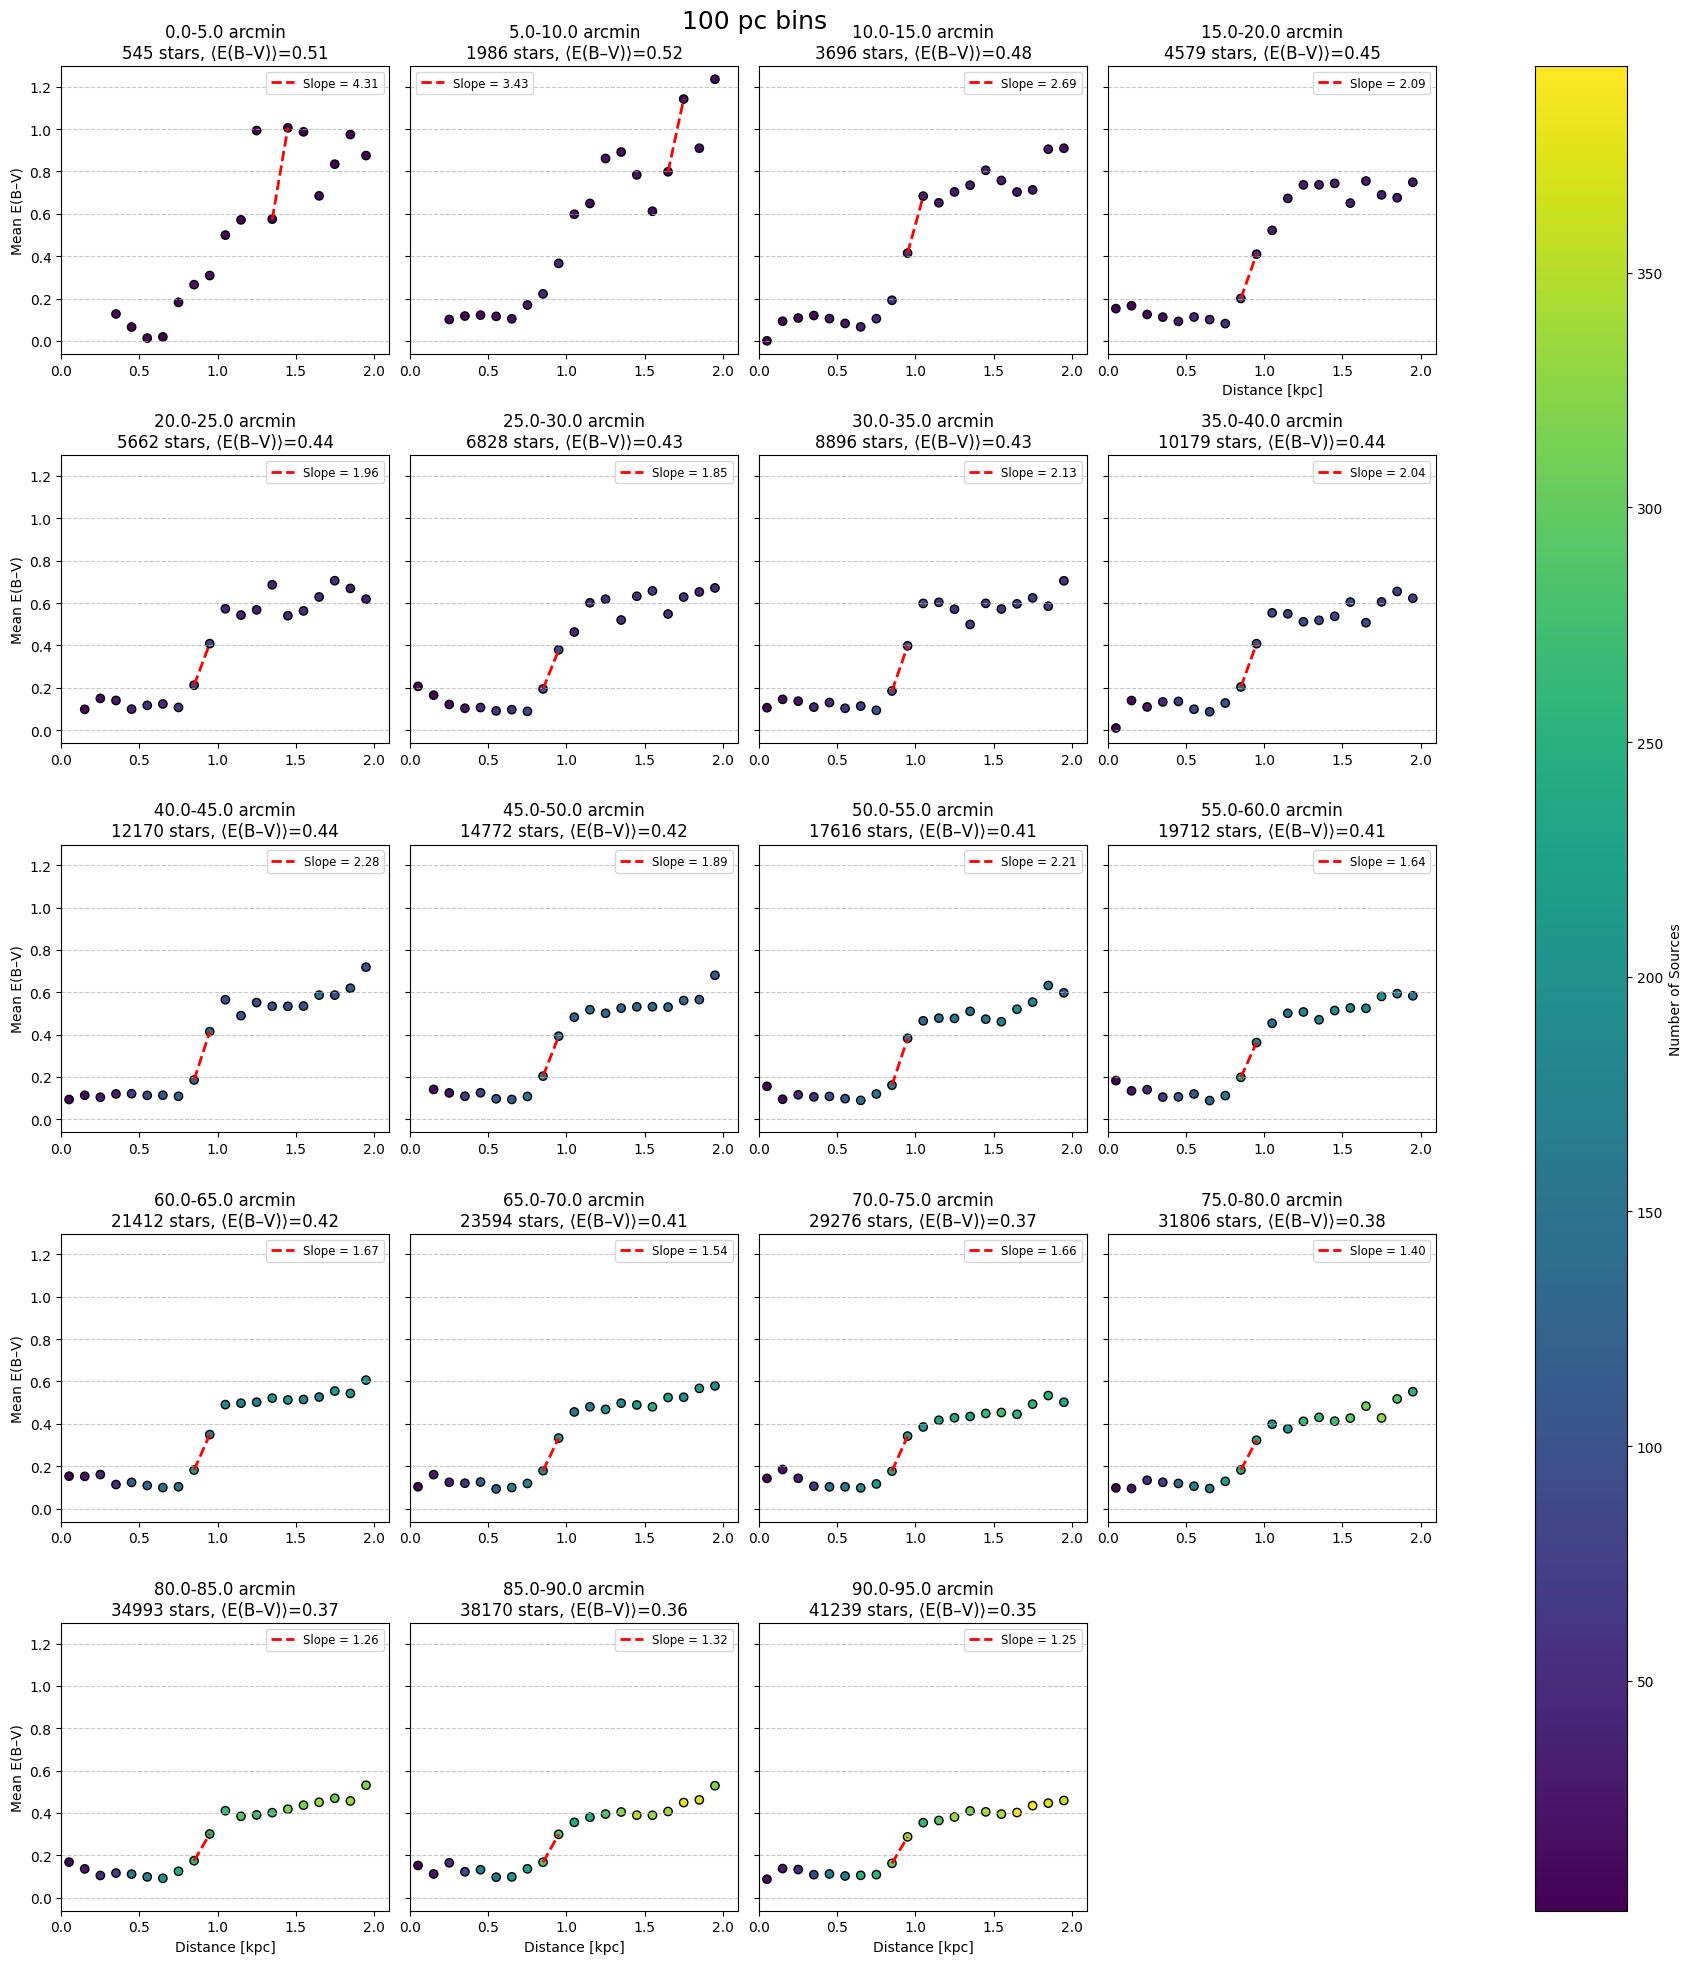

In [42]:
ncols = 4
nrows = int(np.ceil(len(radii) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), sharey=True)
axes = axes.flatten()

all_counts = []

precomputed = []

for radius in radii:
    maskradius = (sep.to(u.arcmin) >= (radius - 5.0 * u.arcmin)) & (sep.to(u.arcmin) <= (radius))
    t_annulus = t[maskradius]

    plx = t_annulus['parallax'][~np.isnan(t_annulus['ag_gspphot'])]
    distance = 1 / plx * u.kpc
    Ag = t_annulus['ag_gspphot'][~np.isnan(t_annulus['ag_gspphot'])]
    ebv = Ag / 3.2

    mask = distance < 2.0 * u.kpc
    distance_zoom = distance[mask]
    ebv_zoom = ebv[mask]

    bins = np.arange(0, 2.0 + 0.1, 0.1) * u.kpc
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    mean_ebv = []
    counts = []
    bin_centers_used = []

    for i in range(len(bins) - 1):
        bin_mask = (distance_zoom >= bins[i]) & (distance_zoom < bins[i + 1])
        count = np.sum(bin_mask)

        if count > 0:
            mean = np.mean(ebv_zoom[bin_mask])
            mean_ebv.append(mean)
            counts.append(count)
            bin_centers_used.append(bin_centers[i].value)  # convert to float here!

    all_counts.extend(counts)

    precomputed.append({
        'radius': radius,
        'bin_centers': bin_centers_used,  # no units anymore
        'mean_ebv': mean_ebv,
        'counts': counts,
        'n_stars': len(t_annulus),
        'mean_ebv_total': np.mean(ebv_zoom) if len(ebv_zoom) > 0 else 0
    })

vmin = min(all_counts)
vmax = max(all_counts)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.viridis

for i, pre in enumerate(precomputed):
    ax = axes[i]

    x = np.array(pre['bin_centers'])
    y = np.array(pre['mean_ebv'])

    dx = x[1:] - x[:-1]
    dy = y[1:] - y[:-1]
    slopes = dy / dx

    max_slope_idx = np.argmax(np.abs(slopes))
    max_slope = slopes[max_slope_idx]

    x_line = [x[max_slope_idx], x[max_slope_idx + 1]]
    y_line = [y[max_slope_idx], y[max_slope_idx + 1]]

    sc = ax.scatter(x, y,
                    c=pre['counts'], cmap=cmap, norm=norm,
                    edgecolor='k')

    ax.plot(x_line, y_line, color='red', linewidth=2, linestyle='--', label=f"Slope = {max_slope:.2f}")

    ax.set_xlim(0, 2.1)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    ax.set_title(f"{(pre['radius'].value) - 5}-{pre['radius'].value} arcmin\n"
                 f"{pre['n_stars']} stars, ⟨E(B–V)⟩={pre['mean_ebv_total']:.2f}")

    if i % ncols == 0:
        ax.set_ylabel('Mean E(B–V)')
    if i >= (nrows - 1) * ncols:
        ax.set_xlabel('Distance [kpc]')
    if i == (ncols - 1):
        ax.set_xlabel('Distance [kpc]')

    ax.xaxis.set_tick_params(labelbottom=True)

    ax.legend(fontsize='small')

for j in range(len(radii), len(axes)):
    fig.delaxes(axes[j])

steepest_distances = []

for pre in precomputed:
    x = np.array(pre['bin_centers'])
    y = np.array(pre['mean_ebv'])

    if len(x) < 2:
        continue  # not enough bins to compute slope

    dx = x[1:] - x[:-1]
    dy = y[1:] - y[:-1]
    slopes = dy / dx

    max_slope_idx = np.argmax(np.abs(slopes))
    distance_at_max_slope = 0.5 * (x[max_slope_idx] + x[max_slope_idx + 1])
    steepest_distances.append(distance_at_max_slope)

# Compute and print the average
if steepest_distances:
    avg_steepest_distance = np.mean(steepest_distances)
    print(f"Average distance at which the steepest slope occurs: {avg_steepest_distance:.2f} kpc")
else:
    print("No valid steepest slope distances were found.")


fig.suptitle("100 pc bins", fontsize=18, x=0.38)
plt.tight_layout(rect=[0, 0, 0.9, 1])
cbar = fig.colorbar(sc, ax=axes, orientation='vertical')
cbar.set_label('Number of Sources')

plt.savefig("reddening_annulus.png", bbox_inches='tight')
plt.show()

4


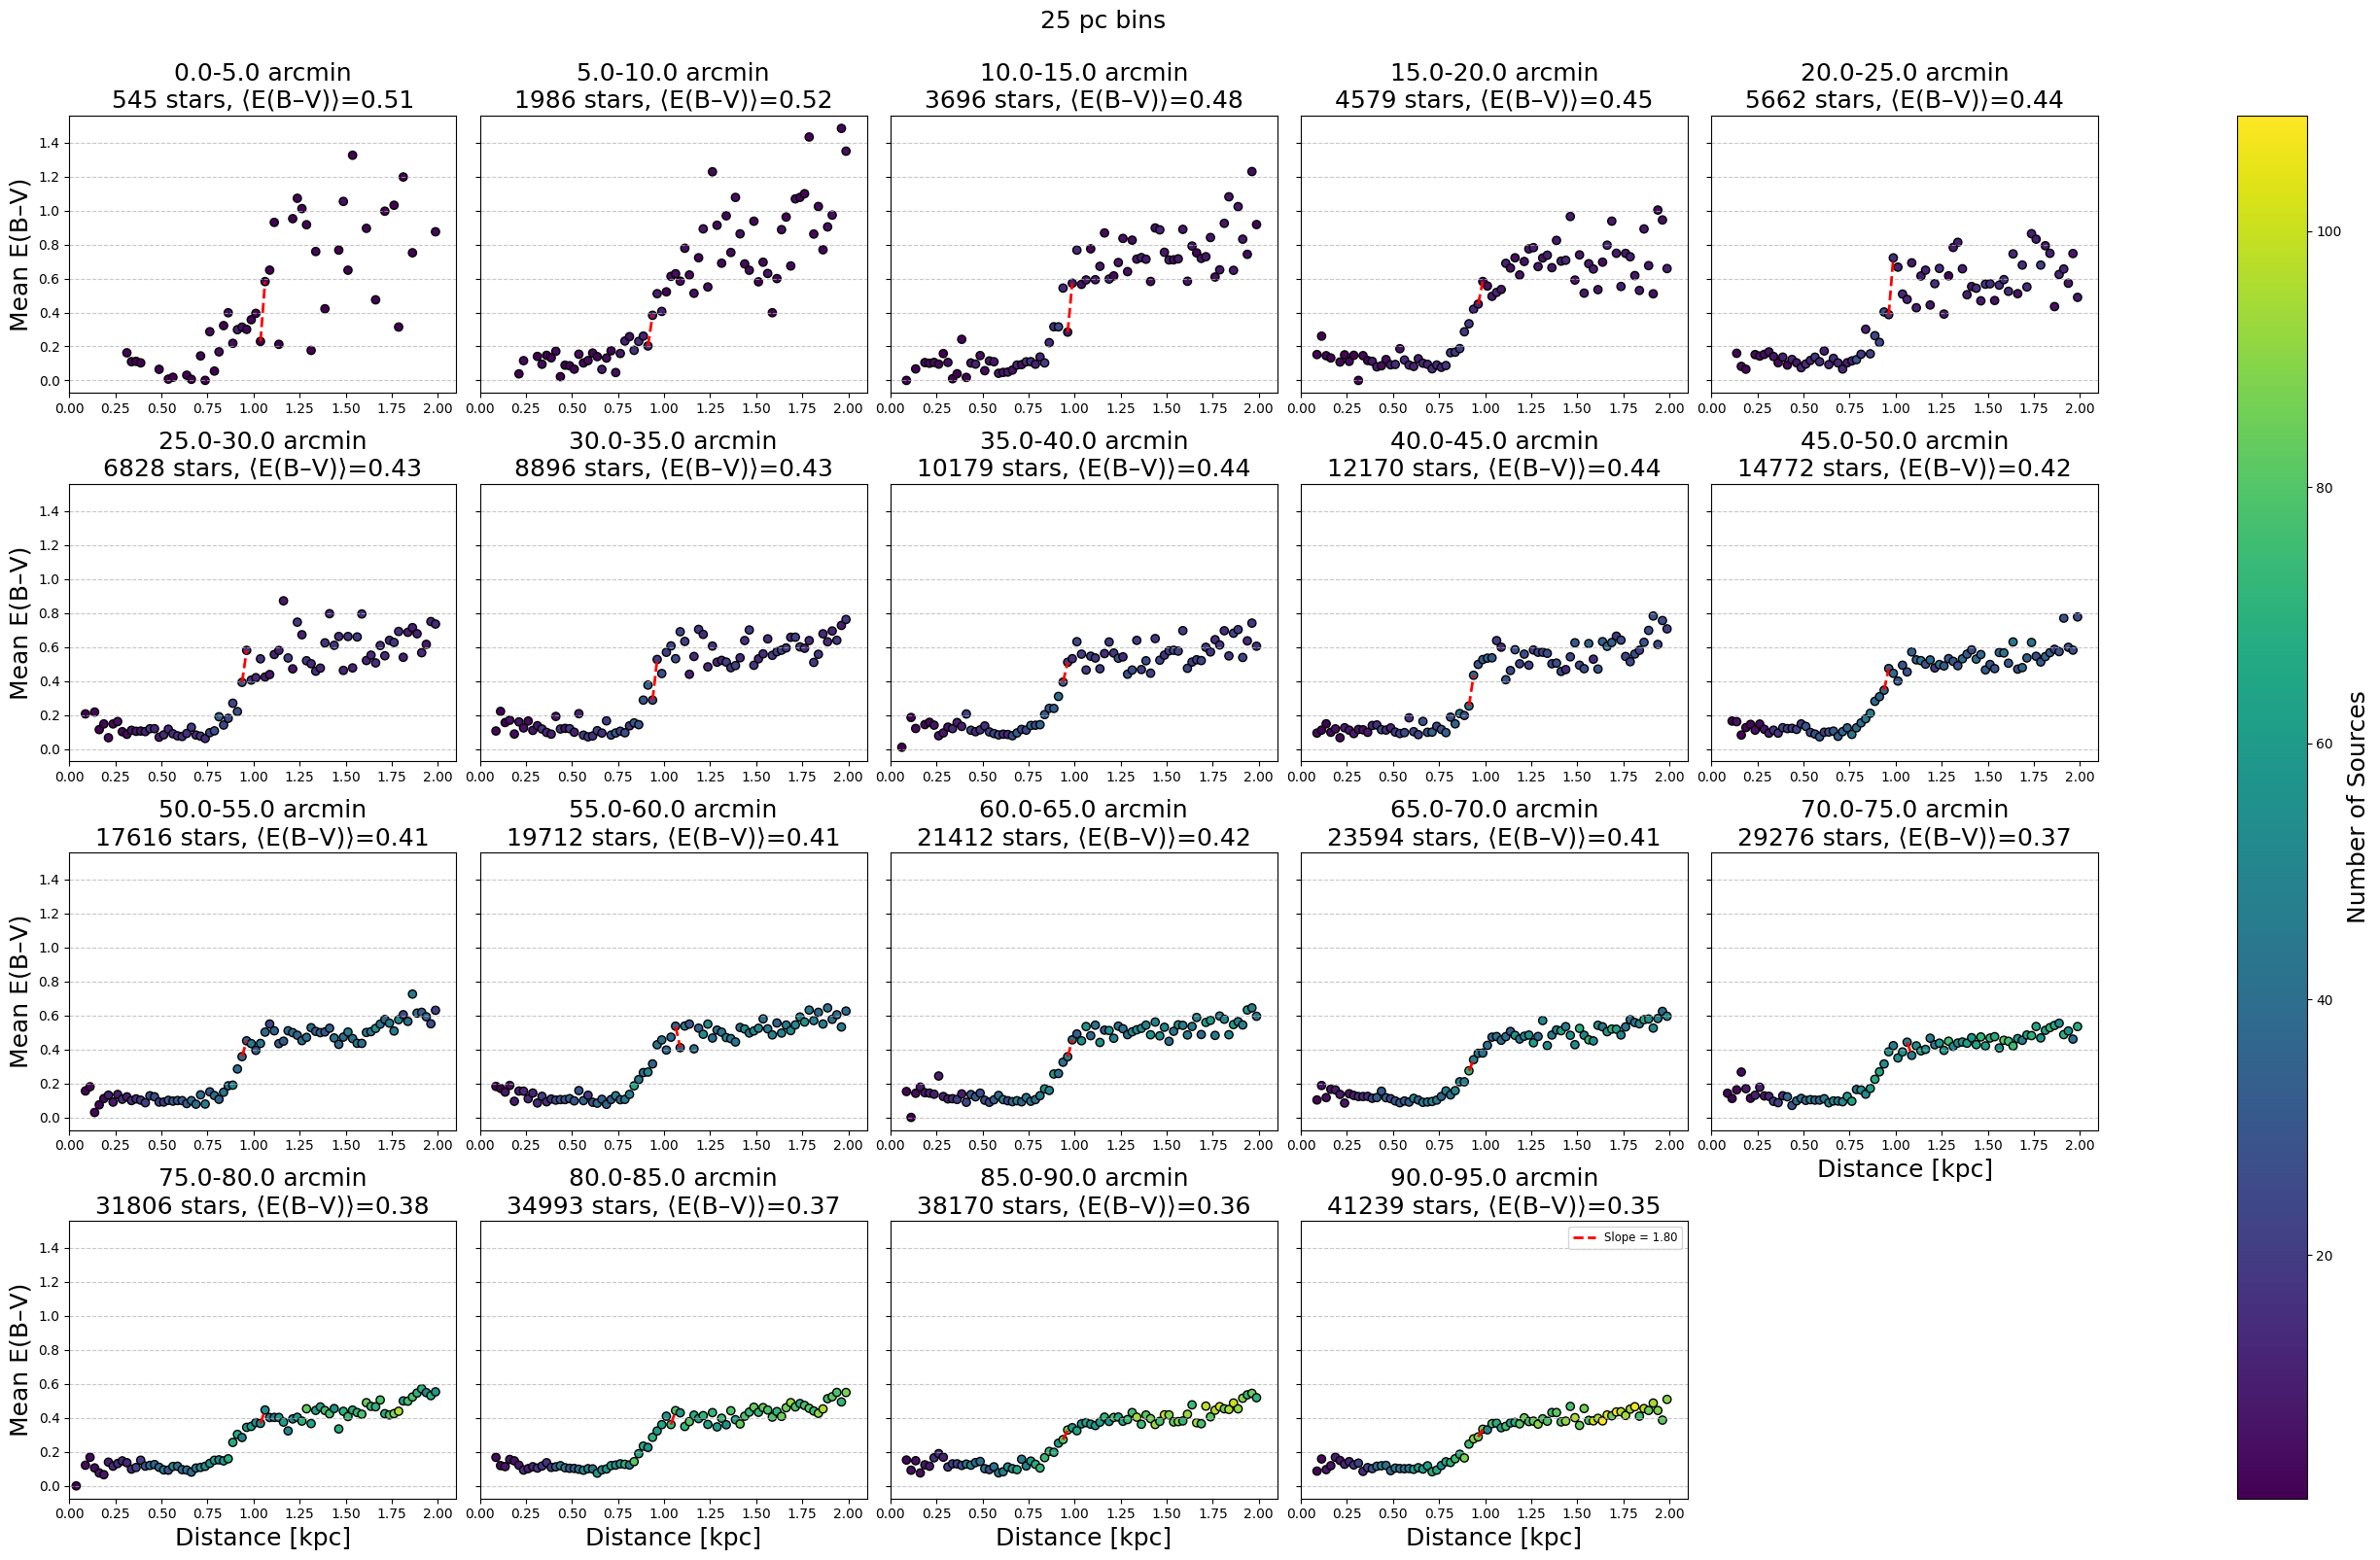

In [43]:
ncols = 5
nrows = int(np.ceil(len(radii) / ncols))
print(nrows)
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows), sharey=True)
axes = axes.flatten()

all_counts = []

precomputed = []

for radius in radii:
    maskradius = (sep.to(u.arcmin) >= (radius - 5.0 * u.arcmin)) & (sep.to(u.arcmin) <= (radius))
    t_annulus = t[maskradius]

    plx = t_annulus['parallax'][~np.isnan(t_annulus['ag_gspphot'])]
    distance = 1 / plx * u.kpc
    Ag = t_annulus['ag_gspphot'][~np.isnan(t_annulus['ag_gspphot'])]
    ebv = Ag / 3.2

    mask = distance < 2.0 * u.kpc
    distance_zoom = distance[mask]
    ebv_zoom = ebv[mask]

    bins = np.arange(0, 2.0 + 0.1, 0.025) * u.kpc
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    mean_ebv = []
    counts = []
    bin_centers_used = []

    for i in range(len(bins) - 1):
        bin_mask = (distance_zoom >= bins[i]) & (distance_zoom < bins[i + 1])
        count = np.sum(bin_mask)

        if count > 0:
            mean = np.mean(ebv_zoom[bin_mask])
            mean_ebv.append(mean)
            counts.append(count)
            bin_centers_used.append(bin_centers[i].value)  

    all_counts.extend(counts)

    precomputed.append({
        'radius': radius,
        'bin_centers': bin_centers_used,  
        'mean_ebv': mean_ebv,
        'counts': counts,
        'n_stars': len(t_annulus),
        'mean_ebv_total': np.mean(ebv_zoom) if len(ebv_zoom) > 0 else 0
    })
    
vmin = min(all_counts)
vmax = max(all_counts)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.viridis

for i, pre in enumerate(precomputed):
    ax = axes[i]

    x = np.array(pre['bin_centers'])  
    y = np.array(pre['mean_ebv'])     

    mask_range = (x >= 0.9) & (x <= 1.1)

    if np.sum(mask_range) > 1:
        x_masked = x[mask_range]
        y_masked = y[mask_range]

        dx = x_masked[1:] - x_masked[:-1]
        dy = y_masked[1:] - y_masked[:-1]
        slopes = dy / dx

        max_slope_idx = np.argmax(np.abs(slopes))
        max_slope = slopes[max_slope_idx]

        x_line = [x_masked[max_slope_idx], x_masked[max_slope_idx + 1]]
        y_line = [y_masked[max_slope_idx], y_masked[max_slope_idx + 1]]

        ax.plot(x_line, y_line, color='red', linewidth=2, linestyle='--',
                label=f"Slope = {max_slope:.2f}")
        sc = ax.scatter(x, y,
                    c=pre['counts'], cmap=cmap, norm=norm,
                    edgecolor='k')

    ax.set_xlim(0, 2.1)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    ax.set_title(f"{(pre['radius'].value) - 5}-{pre['radius'].value} arcmin\n"
                 f"{pre['n_stars']} stars, ⟨E(B–V)⟩={pre['mean_ebv_total']:.2f}", fontsize=18)

    if i % ncols == 0:
        ax.set_ylabel('Mean E(B–V)', fontsize=18)
    if i >= (nrows - 1) * ncols:
        ax.set_xlabel('Distance [kpc]', fontsize=18)
    if i == 14:  # subplot at row 3, col 5
        ax.set_xlabel('Distance [kpc]', fontsize=18)

ax.xaxis.set_tick_params(labelbottom=True)

ax.legend(fontsize='small')

for j in range(len(radii), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("25 pc bins", fontsize=18, x=0.38, y=1)
plt.tight_layout(rect=[0, 0, 0.9, 1])
cbar = fig.colorbar(sc, ax=axes, orientation='vertical')
cbar.set_label('Number of Sources', fontsize=18)

plt.savefig("reddening_annulus.png", bbox_inches='tight')
plt.show()

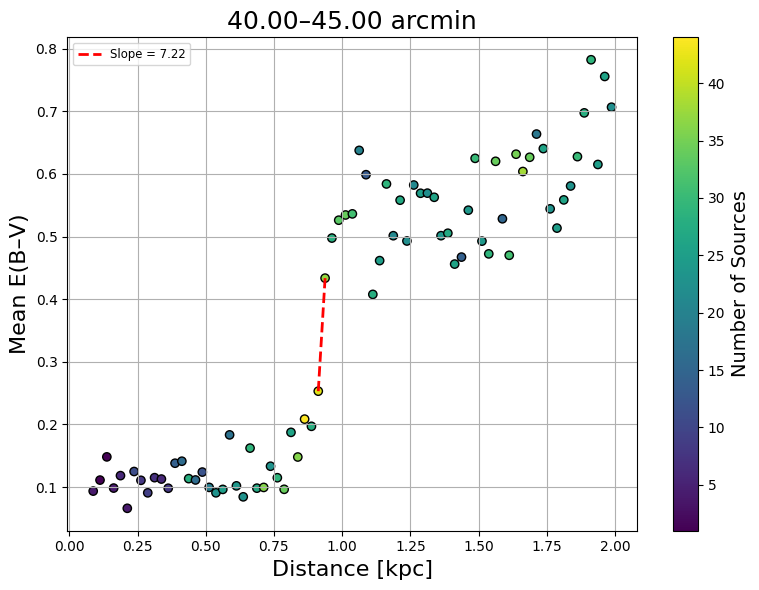

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm, colors
import astropy.units as u

# Target radius
target_radius = 45.0 * u.arcmin
inner_radius = target_radius - 5.0 * u.arcmin

# Mask the annulus
maskradius = (sep.to(u.arcmin) >= inner_radius) & (sep.to(u.arcmin) <= target_radius)
t_annulus = t[maskradius]

# Prepare data
plx = t_annulus['parallax'][~np.isnan(t_annulus['ag_gspphot'])]
distance = 1 / plx * u.kpc
Ag = t_annulus['ag_gspphot'][~np.isnan(t_annulus['ag_gspphot'])]
ebv = Ag / 3.2

mask = distance < 2.0 * u.kpc
distance_zoom = distance[mask]
ebv_zoom = ebv[mask]

bins = np.arange(0, 2.0 + 0.1, 0.025) * u.kpc
bin_centers = 0.5 * (bins[:-1] + bins[1:])

mean_ebv = []
counts = []
bin_centers_used = []

for i in range(len(bins) - 1):
    bin_mask = (distance_zoom >= bins[i]) & (distance_zoom < bins[i + 1])
    count = np.sum(bin_mask)
    if count > 0:
        mean = np.mean(ebv_zoom[bin_mask])
        mean_ebv.append(mean)
        counts.append(count)
        bin_centers_used.append(bin_centers[i].value)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
x = np.array(bin_centers_used)
y = np.array(mean_ebv)
cmap = cm.viridis
norm = colors.Normalize(vmin=min(counts), vmax=max(counts))

# Plot max slope in range 0.9–1.1 kpc
mask_range = (x >= 0.9) & (x <= 1.1)
if np.sum(mask_range) > 1:
    x_masked = x[mask_range]
    y_masked = y[mask_range]
    dx = x_masked[1:] - x_masked[:-1]
    dy = y_masked[1:] - y_masked[:-1]
    slopes = dy / dx
    max_slope_idx = np.argmax(np.abs(slopes))
    x_line = [x_masked[max_slope_idx], x_masked[max_slope_idx + 1]]
    y_line = [y_masked[max_slope_idx], y_masked[max_slope_idx + 1]]
    ax.plot(x_line, y_line, color='red', linewidth=2, linestyle='--',
            label=f"Slope = {slopes[max_slope_idx]:.2f}")

sc = ax.scatter(x, y, c=counts, cmap=cmap, norm=norm, edgecolor='k')

ax.set_title("40.00–45.00 arcmin", fontsize=18)
ax.set_xlabel('Distance [kpc]', fontsize=16)
ax.set_ylabel('Mean E(B–V)', fontsize=16)
ax.grid(True)
ax.legend(fontsize='small')
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('Number of Sources', fontsize=14)

plt.tight_layout()
plt.savefig("annulus_40_45_arcmin.png", dpi=300)
plt.show()


TypeError: 'Quantity' object with a scalar value does not support indexing

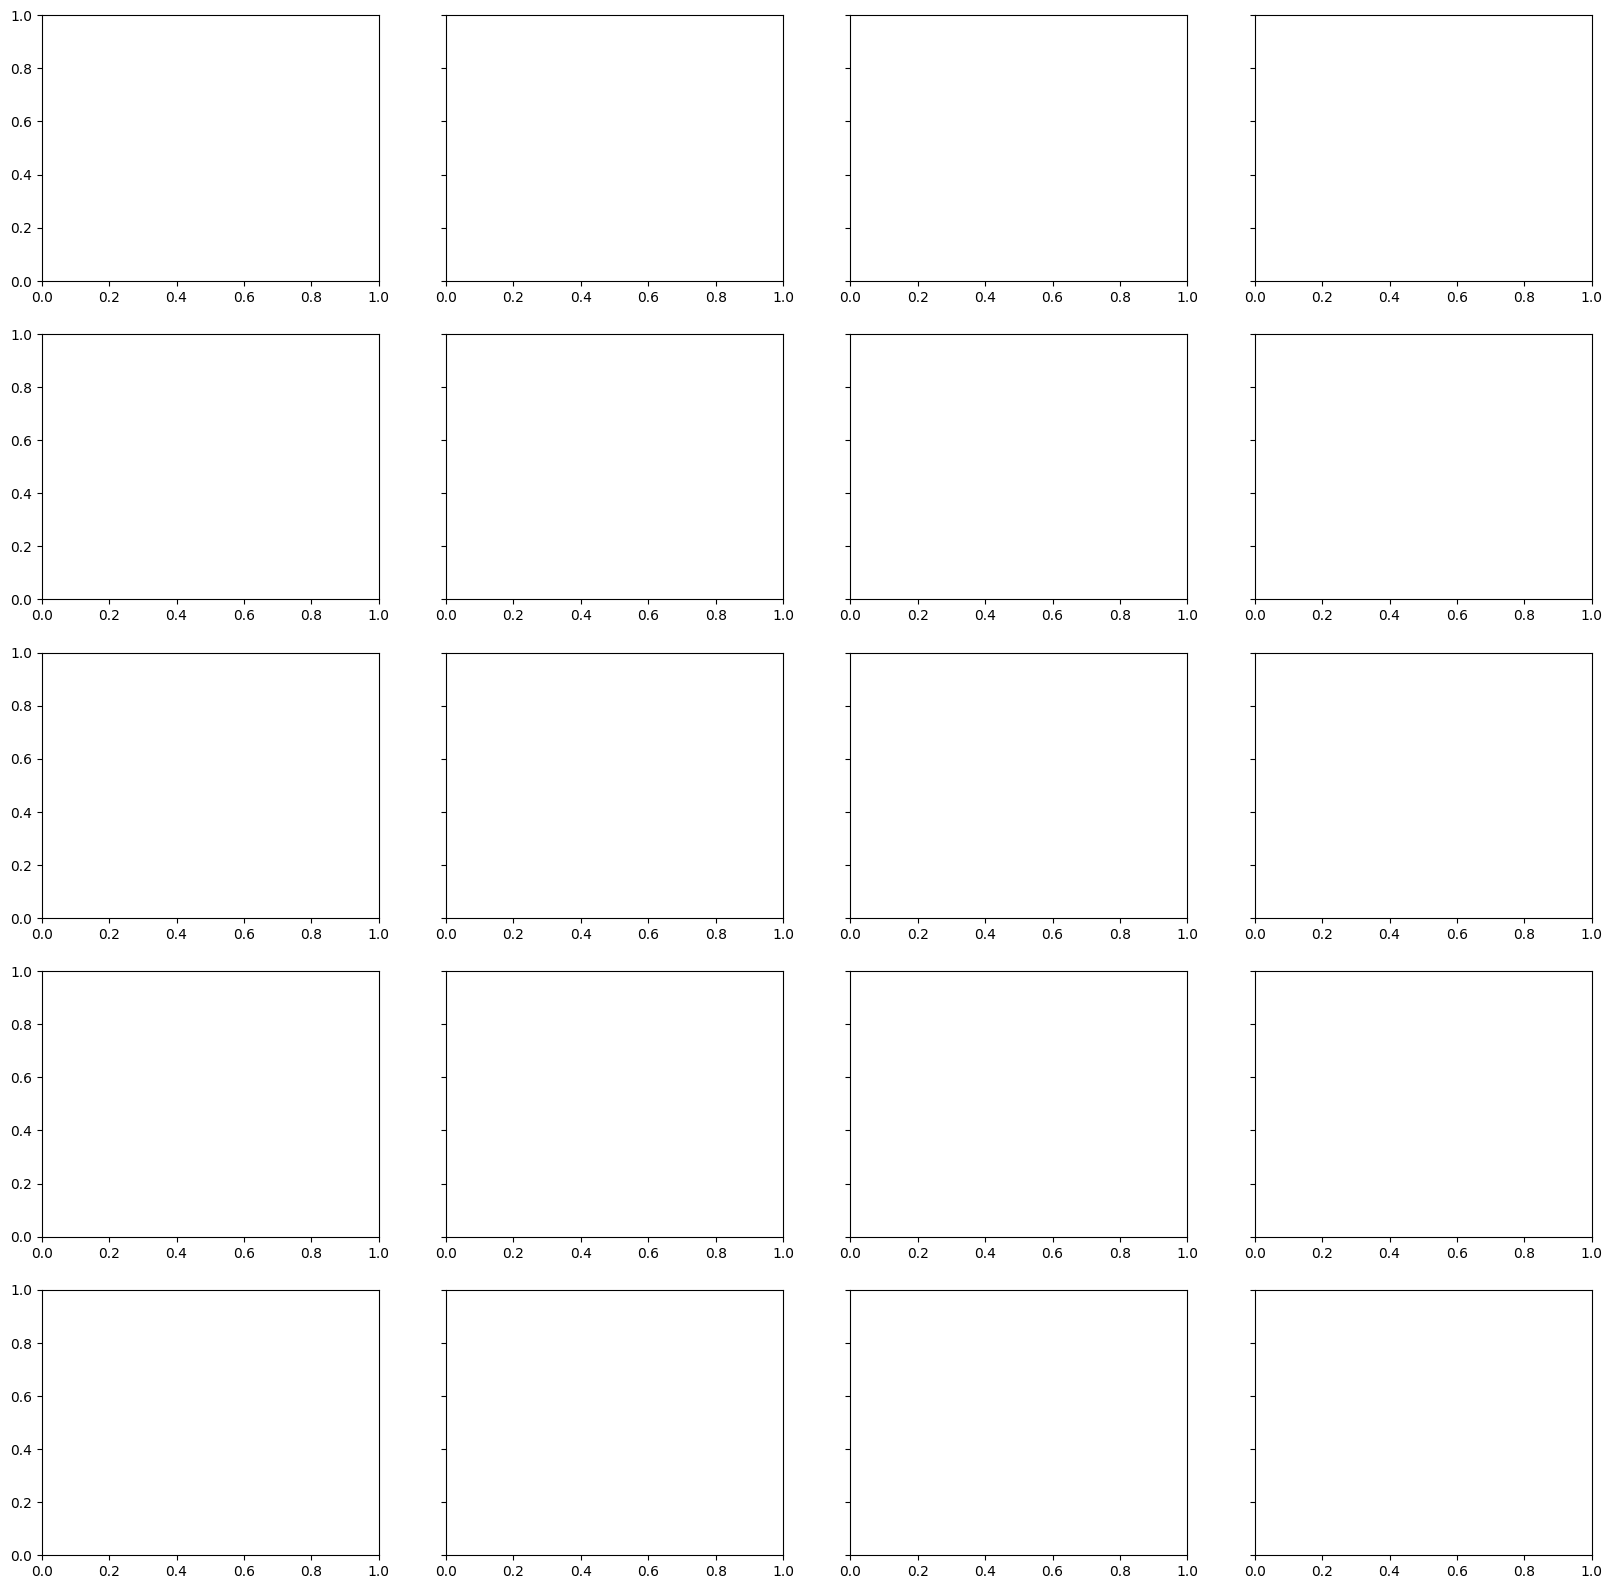

In [45]:
ncols = 4
nrows = int(np.ceil(len(radii) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), sharey=True)
axes = axes.flatten()

precomputed = []

for radius in radii:
    maskradius = (sep.to(u.arcmin) >= radius[0]) & (sep.to(u.arcmin) <= radius[1])
    t_annulus = t[maskradius]

    plx = t_annulus['parallax']
    Ag = t_annulus['AG50']
    ebv = Ag / 3.2

    mask = plx > 0
    distance = (1 / plx[mask]) * u.kpc
    ebv = ebv[mask]

    mask = distance < 2.0 * u.kpc
    distance_zoom = distance[mask]
    ebv_zoom = ebv[mask]

    precomputed.append({
        'radius': radius,
        'distance': distance_zoom.value,
        'ebv': ebv_zoom.value,
        'n_stars': len(t_annulus),
        'mean_ebv_total': np.mean(ebv_zoom) if len(ebv_zoom) > 0 else 0
    })

for i, pre in enumerate(precomputed):
    ax = axes[i]

    ax.scatter(pre['distance'], pre['ebv'], s=10, color='blue', alpha=0.7, edgecolor='none')

    ax.set_xlim(0, 2.1)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    ax.set_title(f"{pre['radius'][0].value}-{pre['radius'][1].value} arcmin\n"
                 f"{pre['n_stars']} stars")

    if i % ncols == 0:
        ax.set_ylabel('E(B–V)')
    if i >= (nrows - 1) * ncols:
        ax.set_xlabel('Distance [kpc]')
    if i == (ncols - 1):
        ax.set_xlabel('Distance [kpc]')
        
    ax.xaxis.set_tick_params(labelbottom=True)

for j in range(len(radii), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig("reddening_annulus_individual_stars.png", bbox_inches='tight')
plt.show()
